#### Pre-processing: Route Building 

We would like to construct an alternate route design for  a new Manhattan -> LGA Airport bus service. The benchmark system is a shuttle service (the Q70 LGA Shuttle) that runs from Jackson Heights/Woodside to all airport terminals, resulting in a majority of ridership relying on system transfers to complete the "last-mile". The goal is to build an optimal bus route that eliminates the need for this mid-journey transfer, in order to reduce idling times for service and to provide a direct connection to LGA Airport, without the construction costs needed to build a service with grade-separated infrastructure (a new subway route, an "Airtrain" akin to JFK/EWR). 

The goal is to implement a variant of the MCSP (maximal coverage - shortest path) problem to construct this new route. Parameters are governed based on passenger demand and route-based costs (distance and time), drawn from a combination of OD-pair ridership estimates (NYS Open Data), bus location pings (real-time GTFS - for the Q70 service), and OSM route-based attributes (osmnx). The two deliverables/inputs for the model include: 

* $d$, an $m \times 1$ sized vector of demands per nodes. Nodes here are defined as coverage spots and are analogous to subway stations located in Manhattan south of 60th street. The goal is to find which nodes could serve as contenders for stops along this new route (to maximize coverage and minimize accumulated route-based costs). These are gathered from the subway OD-pair dataset in conjunction with estimates drawn from the GTFS feed. This is mainly used for the set-coverage component of the problem
* $D$ and $T$, two $m \times m$ matrices of distances (or times) between each pair of nodes. This is drawn from the `osmnx` python package and its functionality. This is important for determining an optimal route between the coverage-optimized nodes that were selected as stops; in other words, finding a route that minimizes total accumulated costs. 

##### Gather Data Sources

Two Items: 
* `GTFS` feed data acquired by the `load_bus_locations.py` script. This is located in the `q70` table in a local sqlite db. Includes real-time passenger count estimates from the `q70` service.
* `subway_od_pair_demand` (OD Pair aggregated ridership estimates between Manhattan subway stops to Jackson Heights/Woodside), `manhattan_subway_metadata` (metadata associated w/ each subway complex in Manhattan south of 60th st), also tables located in the same local sqlite db. 

In [42]:
import sqlite3
import pandas as pd

db_path = '../data_playground/bus_locations_benchmark2.db'
con = sqlite3.connect(db_path)
q70_passenger_estimates = pd.read_sql(
'''
select * from (
    select distinct 
        VehicleID, 
        strftime('%H' , RecordTime) as hour, 
        strftime('%d', RecordTime) as day,
        avg(EstimatedPassengerCount) as ttl_ridership_estimate
    from q70
    where 
        EstimatedPassengerCount is not null 
        and StopPointName = "LGA INTERNAL RDWY/TERMINAL C"
    group by 1,2,3
    order by 1
) 
where day in ('26','27')
;
''', 
con = con
)

q70_passenger_estimates

VehicleID hour day  ttl_ridership_estimate
0   MTABC_6070   15  26                    32.0
1   MTABC_6274   13  26                    22.0
2   MTABC_6274   19  26                    37.0
3   MTABC_6274   20  26                    42.0
4   MTABC_6275   00  27                     7.0
..         ...  ...  ..                     ...
64  MTABC_6286   19  26                    49.0
65  MTABC_6286   19  27                    31.0
66  MTABC_6286   20  26                    48.5
67  MTABC_6286   23  27                    21.0
68  MTABC_9301   22  26                    80.0

[69 rows x 4 columns]

In [62]:
subway_od_pair_estimates = \
pd.read_sql(
''' 
select 
    m.complex_id, 
    avg(m.gtfs_latitude) as lat, 
    avg(m.gtfs_longitude) as long, 
    avg(od.ttl_ridership) as ttl_ridership
from manhattan_subway_metadata m 
inner join (
select 
    origin_station_complex_id as complex_id, 
    sum(SUM_estimated_average_ridership) / 212 as ttl_ridership
from subway_od_pair_demand
group by 1
) od using (complex_id)
group by 1
order by 4 desc
;
''', 
con = con
)

subway_od_pair_estimates

complex_id        lat       long  ttl_ridership
0         611  40.755746 -73.987581     546.590914
1         610  40.751992 -73.977359     329.599541
2         607  40.749643 -73.987887     318.945230
3         609  40.754022 -73.983266     241.285340
4         225  40.758663 -73.981329     226.830780
..        ...        ...        ...            ...
60        325  40.722854 -74.006277       6.175954
61        118  40.732849 -73.986122       4.895359
62        329  40.707513 -74.013783       3.971642
63        107  40.706476 -74.011056       2.242308
64        103  40.720280 -73.993915       1.514266

[65 rows x 4 columns]

#### Build demand vector (demand quantities per node)

Define the following parameters:

* $s_i$ : the approximate daily figure of subway riders from stop $i$ to Jackson Heights/Woodside (sourced from NYS Open Data)
* $b$ : the approximate daily figure of q70 bus ridership (sourced from GTFS feed data)

We would like to consider the following:

* What proportion of OD-pair ridership $s_i$ will transfer at Jackson Heights/Woodside for the Q70?
* What proportion of subway traffic into Jackson Heights/Woodside is from Manhattan below 60th st?


In [90]:
#approximate daily q70 ridership from the saved gtfs feed data
daily_q70_ridership_estimate = q70_passenger_estimates['ttl_ridership_estimate'].sum()

ttl_traffic = \
pd.read_sql('''select sum(SUM_estimated_average_ridership) / 212 from subway_od_pair_demand;''',con=con)

#what proportion of q70 ridership are Manhattan riders? approximate based on subway OD pair data to Jackson Heights
ttl_traffic = ttl_traffic.iloc[0][0]
manh_cbd_only = subway_od_pair_estimates['ttl_ridership'].sum() 
prop_manh_cbd_only = manh_cbd_only / ttl_traffic
corr = daily_q70_ridership_estimate*prop_manh_cbd_only

subway_od_pair_estimates['demand_weight'] = \
subway_od_pair_estimates['ttl_ridership']/subway_od_pair_estimates['ttl_ridership'].sum() 

subway_od_pair_estimates['d'] = subway_od_pair_estimates['demand_weight']*corr
#subway_od_pair_estimates.to_csv('inputs/demands.csv')

subway_od_pair_estimates

/var/folders/wx/wz1pbs1903j_cfgqws400dz80000gn/T/ipykernel_56005/143868194.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ttl_traffic = ttl_traffic.iloc[0][0]


complex_id        lat       long  ttl_ridership  demand_weight          d  \
0         611  40.755746 -73.987581     546.590914       0.105116  81.312525   
1         610  40.751992 -73.977359     329.599541       0.063386  49.032229   
2         607  40.749643 -73.987887     318.945230       0.061337  47.447261   
3         609  40.754022 -73.983266     241.285340       0.046402  35.894340   
4         225  40.758663 -73.981329     226.830780       0.043622  33.744036   
..        ...        ...        ...            ...            ...        ...   
60        325  40.722854 -74.006277       6.175954       0.001188   0.918754   
61        118  40.732849 -73.986122       4.895359       0.000941   0.728248   
62        329  40.707513 -74.013783       3.971642       0.000764   0.590833   
63        107  40.706476 -74.011056       2.242308       0.000431   0.333572   
64        103  40.720280 -73.993915       1.514266       0.000291   0.225267   

    osmnx_node_id  
0        42439972  
1      9140654137  
2        42430304  
3        42430329  
4        42430352  
..            ...  
60       42452015  
61       42431461  
62     4149936245  
63       42432679  
64     1773076511  

[65 rows x 7 columns]

##### Build Cost Matrices (Distance/Time) per Link/Node Pairing

Use `osmnx` to compute costs per link/pairing between nodes

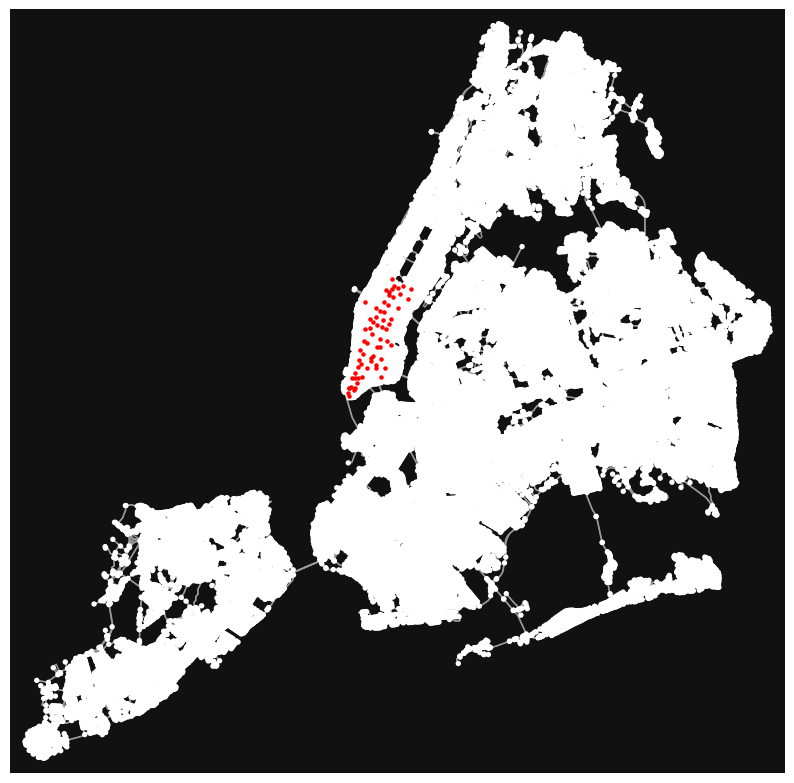

In [69]:
import osmnx as ox
import matplotlib.pyplot as plt 

G = ox.graph_from_place('New York, New York', network_type='drive')

G = ox.add_edge_speeds(G)
G = ox.add_edge_travel_times(G)

lats = subway_od_pair_estimates['lat'].astype(float)
longs = subway_od_pair_estimates['long'].astype(float)

stops = ox.nearest_nodes(G, longs, lats)
subway_od_pair_estimates['osmnx_node_id'] = stops 

nodes, edges = ox.graph_to_gdfs(G, nodes=True)
nodes = nodes.loc[stops]

fig, ax = ox.plot_graph(G, show=False, close=False, figsize=(10,10))
nodes.plot(ax=ax, color="red", markersize=5)

plt.show()


In [235]:
import os

def calculate_costs(G, lst, i, weight_type='length'):
    temp = []

    #apply dijkstra's algo to every node pair...
    for j in lst:
        r = [k for k in ox.shortest_path(G, i, j, weight=weight_type)] 
        if len(r) == 1: l = 0
        else:
            d=ox.routing.route_to_gdf(G, r)
            l = d[weight_type].sum()
        temp.append(l)
    return temp

def create_matrix(G, stops, weight_type, file, push=True):
    path = f'inputs/{file}.csv'
    if not os.path.exists(path):
        try:
            m = [calculate_costs(G, stops, i, weight_type=weight_type) for i in stops]
        except Exception as e: 
            print(e)
            return []
        
        m_df = pd.DataFrame(m, columns=stops, index=stops)
        if push: m_df.to_csv(path)
    else:
        m_df = pd.read_csv(path, index_col=0)

    return m_df

distances = create_matrix(G, stops, weight_type = 'length', file = 'distances')
times = create_matrix(G, stops, weight_type = 'travel_time', file = 'times')

times

42439972  9140654137    42430304    42430329    42430352  \
42439972      0.000000  104.618769   74.260358   39.102253   88.126574   
9140654137  117.617709    0.000000  112.528984   92.250573  105.131391   
42430304     74.722592  111.612406    0.000000   49.355456   98.379777   
42430329     25.367136   92.871672   99.627494    0.000000   49.024321   
42430352     88.378356  103.685122  155.232209  123.756469    0.000000   
...                ...         ...         ...         ...         ...   
42452015    381.408501  410.085912  306.685909  356.041365  405.065686   
42431461    303.724200  231.000878  229.001607  278.357064  326.308107   
4149936245  553.229069  560.293844  478.506477  527.861933  576.886254   
42432679    571.105465  559.247104  496.382873  545.738329  594.762650   
1773076511  419.915814  347.557242  345.193222  394.548678  442.499721   

              42449961    42435644    42453952    42447020    42428493  ...  \
42439972    196.835182   74.039354  499.577467  265.518408  254.408808  ...   
9140654137  102.749525  161.725135  477.702606  174.127481  200.094639  ...   
42430304    207.088385   49.218414  466.213410  275.771611  188.605444  ...   
42430329    157.732928   99.406490  524.944603  226.416155  253.338963  ...   
42430352    108.708608  162.417710  566.244366  177.391834  288.636399  ...   
...                ...         ...         ...         ...         ...  ...   
42452015    494.309173  330.856866  145.549514  566.057323  216.681224  ...   
42431461    275.208609  278.076432  317.357920  346.956759   48.997722  ...   
4149936245  637.335937  495.955041   68.868413  699.607836  366.889156  ...   
42432679    597.699076  513.831437   86.744809  648.103167  365.842416  ...   
1773076511  410.633366  386.573239  179.084123  482.381516  154.152554  ...   

              42428308  4149936235    42453038    42429661  2821304137  \
42439972    106.129393  544.733860  394.875249  162.650668  473.819832   
9140654137  163.545048  550.271046  447.617202  250.142940  451.716899   
42430304    159.066463  519.912920  370.054309  137.829728  440.227704   
42430329    109.711007  570.100996  420.242385  188.017804  499.186968   
42430352     60.686686  633.112216  483.253605  251.029024  540.258659   
...                ...         ...         ...         ...         ...   
42452015    461.520983  205.556066   40.847296  231.400851  119.791879   
42431461    386.994793  389.926360  287.272516  154.115266  291.372213   
4149936245  626.619158    4.415774  159.349781  403.221419  108.810001   
42432679    644.495554   81.446675  177.226177  421.097815  126.686396   
1773076511  503.186408  251.652563  151.262190  270.009072  154.171694   

              42452015    42431461  4149936245    42432679  1773076511  
42439972    354.027953  286.744156  540.318086  599.946890  417.763886  
9140654137  406.769906  232.248470  545.855272  576.843430  363.449717  
42430304    329.207013  220.940792  515.497146  566.582833  351.960522  
42430329    379.395089  285.674311  565.685222  625.314026  416.694041  
42430352    442.406309  320.971747  628.696442  666.613788  451.991477  
...                ...         ...         ...         ...         ...  
42452015      0.000000  258.685663  201.140292  245.918937  114.469916  
42431461    246.425220    0.000000  385.510586  384.213066  161.245812  
4149936245  203.816647  401.712428    0.000000   98.907541  254.951912  
42432679    221.693043  386.699719   84.225136    0.000000  211.689862  
1773076511  110.414894  175.009857  247.236789  224.938976    0.000000  

[65 rows x 65 columns]

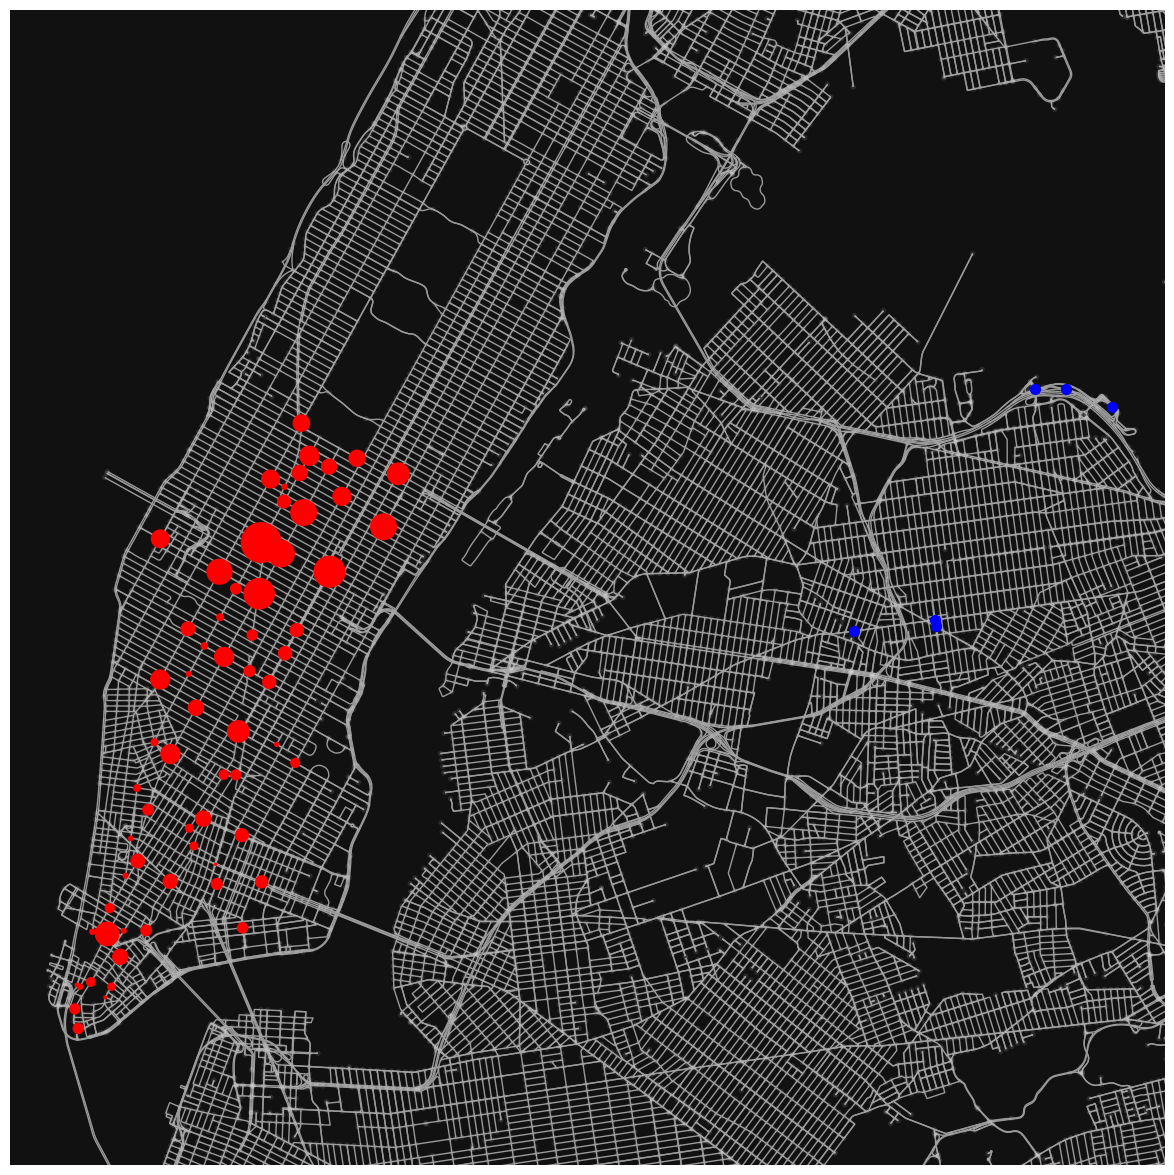

In [159]:
import numpy as np 
import geopandas as gpd

get_airport_loc = pd.read_sql('''select * from q70_stops_metadata;''', con = con)

airport_lats = get_airport_loc['lat'].astype(float)
airport_longs = get_airport_loc['lon'].astype(float)

airport_nodes = ox.nearest_nodes(G, airport_longs, airport_lats)
get_airport_loc['osmnx_node_id'] = airport_nodes

#get_airport_loc
#airport_facility = get_airport_loc.loc[get_airport_loc['name'] == 'LGA INTERNAL RDWY/TERMINAL C']
#airport_facility.iloc[0]
center = (40.75047690227571, -73.94050480138289)
radius = 7000
bbox = ox.utils_geo.bbox_from_point(center, dist=radius)
fig, ax = ox.plot_graph(
    G, 
    show=False, 
    close=False, 
    figsize=(15,15), 
    bbox=bbox, 
    node_alpha=0.1,
)

subway_od_pair_estimates_reindexed = subway_od_pair_estimates.set_index('osmnx_node_id')
manh_demand_stop_nodes = pd.concat((subway_od_pair_estimates_reindexed[['d']], nodes), axis=1)[['d','geometry']]
manh_demand_stop_nodes = gpd.GeoDataFrame(manh_demand_stop_nodes)
manh_demand_stop_nodes.plot(
    ax=ax, 
    color="red", 
    markersize=manh_demand_stop_nodes['d']*10
)

all_nodes, all_edges = ox.graph_to_gdfs(G, nodes=True)
airport_nodes = all_nodes.loc[airport_nodes]
airport_nodes.plot(
    ax=ax, 
    color="blue", 
    markersize=50
)

plt.show()



In [236]:
#add the terminal stop (LGA airport terminals...) to the cost matrices, demand vector
airport_facility_node_id = get_airport_loc.loc[get_airport_loc['name'] == 'LGA INTERNAL RDWY/TERMINAL C']['osmnx_node_id'].iloc[0]
dist_airport_fac = calculate_costs(G, stops, airport_facility_node_id, weight_type='length')
time_airport_fac = calculate_costs(G, stops, airport_facility_node_id, weight_type='travel_time')
distances[airport_facility_node_id] = dist_airport_fac
times[airport_facility_node_id] = time_airport_fac
dist_airport_fac.append(0)
time_airport_fac.append(0)

idx = np.append(stops, airport_facility_node_id)

#row_dist_airport_fac = pd.DataFrame([dist_airport_fac], columns=np.append(stops, airport_facility_node_id), index=[airport_facility_node_id])
#row_time_airport_fac = pd.DataFrame([time_airport_fac], columns=np.append(stops, airport_facility_node_id), index=[airport_facility_node_id])
distances_update = pd.DataFrame(np.vstack((distances.values, np.array(dist_airport_fac))), index=idx, columns=idx)
distances_update.to_csv('inputs/distances_w_airport_fac.csv')
times_update = pd.DataFrame(np.vstack((times.values, np.array(time_airport_fac))), index=idx, columns=idx)
distances_update.to_csv('inputs/times_w_airport_fac.csv')

times_update

42439972    9140654137  42430304    42430329    42430352    \
42439972      0.000000  104.618769   74.260358   39.102253   88.126574   
9140654137  117.617709    0.000000  112.528984   92.250573  105.131391   
42430304     74.722592  111.612406    0.000000   49.355456   98.379777   
42430329     25.367136   92.871672   99.627494    0.000000   49.024321   
42430352     88.378356  103.685122  155.232209  123.756469    0.000000   
...                ...         ...         ...         ...         ...   
42431461    303.724200  231.000878  229.001607  278.357064  326.308107   
4149936245  553.229069  560.293844  478.506477  527.861933  576.886254   
42432679    571.105465  559.247104  496.382873  545.738329  594.762650   
1773076511  419.915814  347.557242  345.193222  394.548678  442.499721   
5969794486  894.760999  821.699236  855.421962  869.393863  917.164954   

            42449961    42435644     42453952    42447020    42428493    ...  \
42439972    196.835182   74.039354   499.577467  265.518408  254.408808  ...   
9140654137  102.749525  161.725135   477.702606  174.127481  200.094639  ...   
42430304    207.088385   49.218414   466.213410  275.771611  188.605444  ...   
42430329    157.732928   99.406490   524.944603  226.416155  253.338963  ...   
42430352    108.708608  162.417710   566.244366  177.391834  288.636399  ...   
...                ...         ...          ...         ...         ...  ...   
42431461    275.208609  278.076432   317.357920  346.956759   48.997722  ...   
4149936245  637.335937  495.955041    68.868413  699.607836  366.889156  ...   
42432679    597.699076  513.831437    86.744809  648.103167  365.842416  ...   
1773076511  410.633366  386.573239   179.084123  482.381516  154.152554  ...   
5969794486  861.016912  904.640375  1073.397674  804.833022  942.375822  ...   

             4149936235   42453038    42429661     2821304137   42452015    \
42439972     544.733860   394.875249  162.650668   473.819832   354.027953   
9140654137   550.271046   447.617202  250.142940   451.716899   406.769906   
42430304     519.912920   370.054309  137.829728   440.227704   329.207013   
42430329     570.100996   420.242385  188.017804   499.186968   379.395089   
42430352     633.112216   483.253605  251.029024   540.258659   442.406309   
...                 ...          ...         ...          ...          ...   
42431461     389.926360   287.272516  154.115266   291.372213   246.425220   
4149936245     4.415774   159.349781  403.221419   108.810001   203.816647   
42432679      81.446675   177.226177  421.097815   126.686396   221.693043   
1773076511   251.652563   151.262190  270.009072   154.171694   110.414894   
5969794486  1145.966114  1045.575741  992.770607  1048.485245  1004.728445   

            42431461     4149936245   42432679    1773076511   5969794486  
42439972    286.744156   540.318086   599.946890  417.763886   894.760999  
9140654137  232.248470   545.855272   576.843430  363.449717   821.699236  
42430304    220.940792   515.497146   566.582833  351.960522   855.421962  
42430329    285.674311   565.685222   625.314026  416.694041   869.393863  
42430352    320.971747   628.696442   666.613788  451.991477   917.164954  
...                ...          ...          ...         ...          ...  
42431461      0.000000   385.510586   384.213066  161.245812   917.417303  
4149936245  401.712428     0.000000    98.907541  254.951912  1141.550340  
42432679    386.699719    84.225136     0.000000  211.689862  1104.541808  
1773076511  175.009857   247.236789   224.938976    0.000000   894.313551  
5969794486  917.417303  1141.550340  1104.541808  894.313551     0.000000  

[66 rows x 66 columns]

In [237]:
manh_demand_stop_nodes_no_geom = manh_demand_stop_nodes[['d']]
s=pd.DataFrame([manh_demand_stop_nodes_no_geom['d'].sum()], index=[airport_facility_node_id], columns=['d'])
demand_vector = pd.concat((manh_demand_stop_nodes_no_geom,s))

demand_vector.to_csv('inputs/demands_w_airport_fac.csv')

In [238]:
demand_vector

d
42439972     81.312525
9140654137   49.032229
42430304     47.447261
42430329     35.894340
42430352     33.744036
...                ...
42431461      0.728248
4149936245    0.590833
42432679      0.333572
1773076511    0.225267
5969794486  773.549793

[66 rows x 1 columns]

##### Maximal Coverage Optimization for Stop Selection 

Identify where to place stops for the alternative route based on the inferred demands calculated above

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 67 rows, 132 columns and 566 nonzeros
Model fingerprint: 0x67933536
Variable types: 0 continuous, 132 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [5e+00, 5e+00]
Found heuristic solution: objective 237.3708776
Presolve removed 5 rows and 9 columns
Presolve time: 0.00s
Presolved: 62 rows, 123 columns, 512 nonzeros
Variable types: 0 continuous, 123 integer (120 binary)
Found heuristic solution: objective 1010.9206702

Root relaxation: objective 1.295460e+03, 78 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     

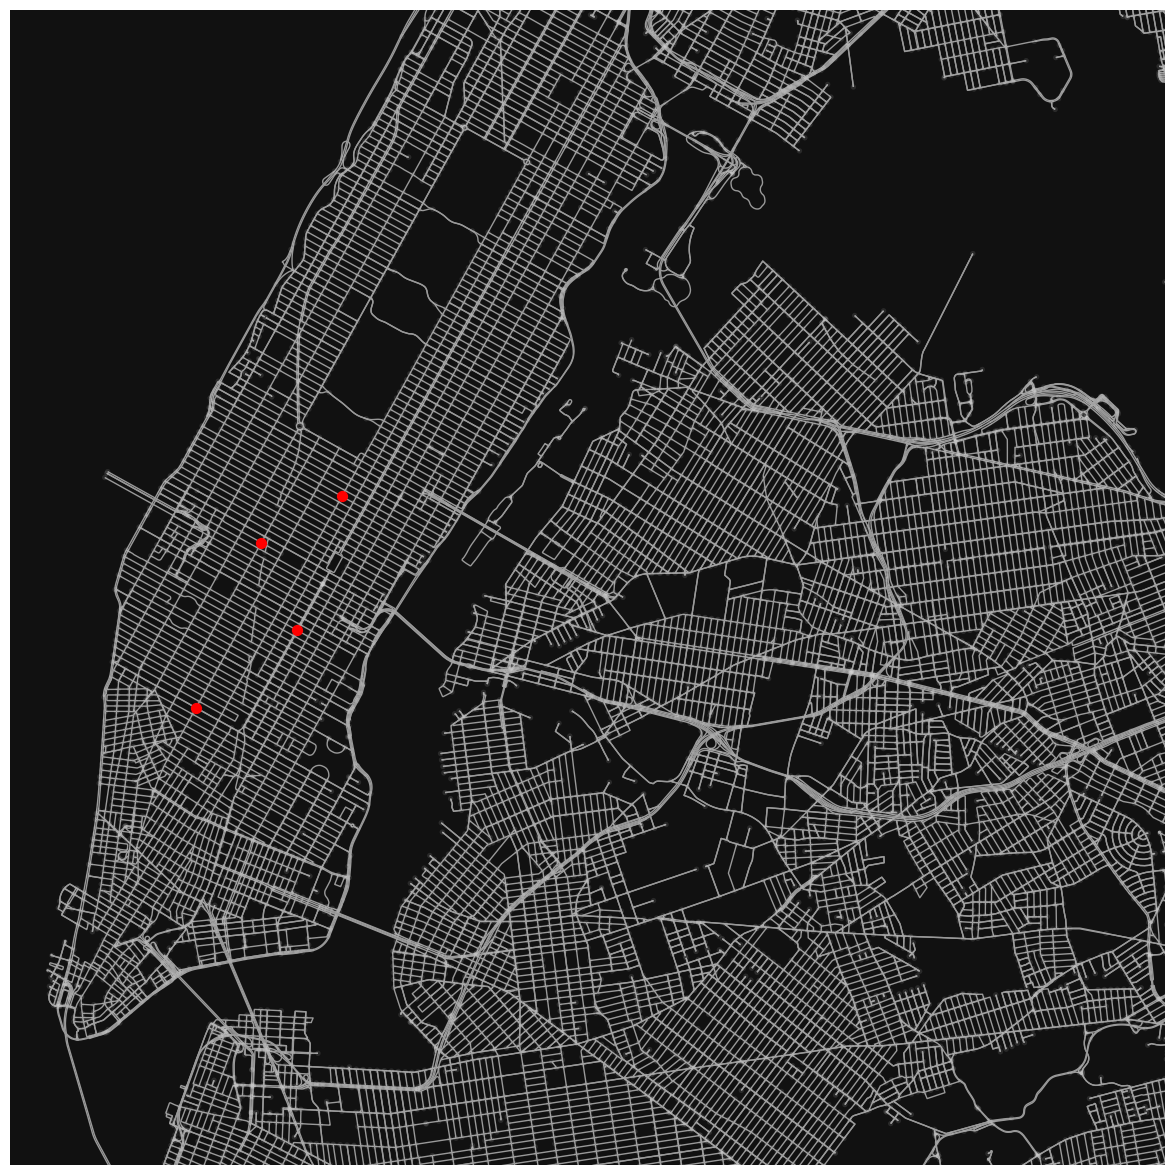

{'Stops': [42439972, 42436700, 42430253, 4597668020, 5969794486],
 'Covered Demand': 1295.4596410931028}

In [277]:
from gurobipy import * 

def search_nearby_nodes(node_id, D, S):
    s=(D.loc[int(node_id)] < S)
    if len(s) < 1:
        return []
    return s[s==True].index

def plot_assignments(assigned_nodes):
    _ , ax = ox.plot_graph(
        G, 
        show=False, 
        close=False, 
        figsize=(15,15), 
        bbox=bbox, 
        node_alpha=0.1,
    )
    assigned_nodes = nodes.loc[assigned_nodes[:-1]]
    assigned_nodes.plot(ax=ax, color="red", markersize=50)
    plt.show()

    pass 

def coverage_optimized_stops(
    num_stops: int, 
    coverage_radius: int, 
    node_demands: pd.DataFrame, 
    link_distances: pd.DataFrame, 
    plot = True
):
    model = Model("Max Coverage Example")

    ttl_stops = num_stops + 1
    node_demands = node_demands['d']

    #define X_i, which determines whether a node is covered...
    vars_covered_id = [f'X_{i}' for i in node_demands.index]
    vars_covered = model.addVars(vars_covered_id, vtype=GRB.INTEGER, name='placements', lb=0, ub=1) 
    vars_covered_arr = np.array(list(vars_covered.values()))

    #define Y_i, determining facility assignment
    vars_fac_id = [f'Y_{i}' for i in node_demands.index]
    vars_fac = model.addVars(vars_fac_id, vtype=GRB.INTEGER, name='placements', lb=0, ub=1) 

    obj_fn = (node_demands*vars_covered_arr).sum() 
    model.setObjective(obj_fn, GRB.MAXIMIZE) 

    #enforce number of stations
    model.addConstr(sum(vars_fac.values()) == ttl_stops)

    #ensure a node is covered by at least one stop...
    for id, x_i in vars_covered.items():
        node_id = id.replace('X_', '')
        N_i = search_nearby_nodes(node_id, link_distances, coverage_radius) 
        coverage_i = 0
        for y_j in N_i: 
            node_id_j = f'Y_{y_j}'
            coverage_i += vars_fac[node_id_j]
        model.addConstr(x_i <= coverage_i)

    model.optimize()
    assigned_stops = [
        int(i.replace('Y_', '')) for i,k in vars_fac.items() if k.X == 1
    ]

    if plot: plot_assignments(assigned_stops)
    
    return {
        'Stops': assigned_stops, 
        'Covered Demand': obj_fn.getValue()
    }

coverage_optimized_stops(
    num_stops=4,
    coverage_radius=1000,
    node_demands=demand_vector, 
    link_distances=distances_update, 
    plot=True
)
#vars_fac

In [278]:
nodes.loc[assigned_stops]

KeyError: '[5969794486] not in index'

Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (mac64[arm] - Darwin 23.3.0 23D56)

CPU model: Apple M3 Pro
Thread count: 11 physical cores, 11 logical processors, using up to 11 threads

Optimize a model with 67 rows, 132 columns and 991 nonzeros
Model fingerprint: 0x2469f5c0
Variable types: 0 continuous, 132 integer (0 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 8e+02]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e+00, 4e+00]
Found heuristic solution: objective 425.4166738
Presolve removed 3 rows and 8 columns
Presolve time: 0.00s
Presolved: 64 rows, 124 columns, 898 nonzeros
Variable types: 0 continuous, 124 integer (119 binary)
Found heuristic solution: objective 1198.9664664

Root relaxation: objective 1.447303e+03, 83 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     

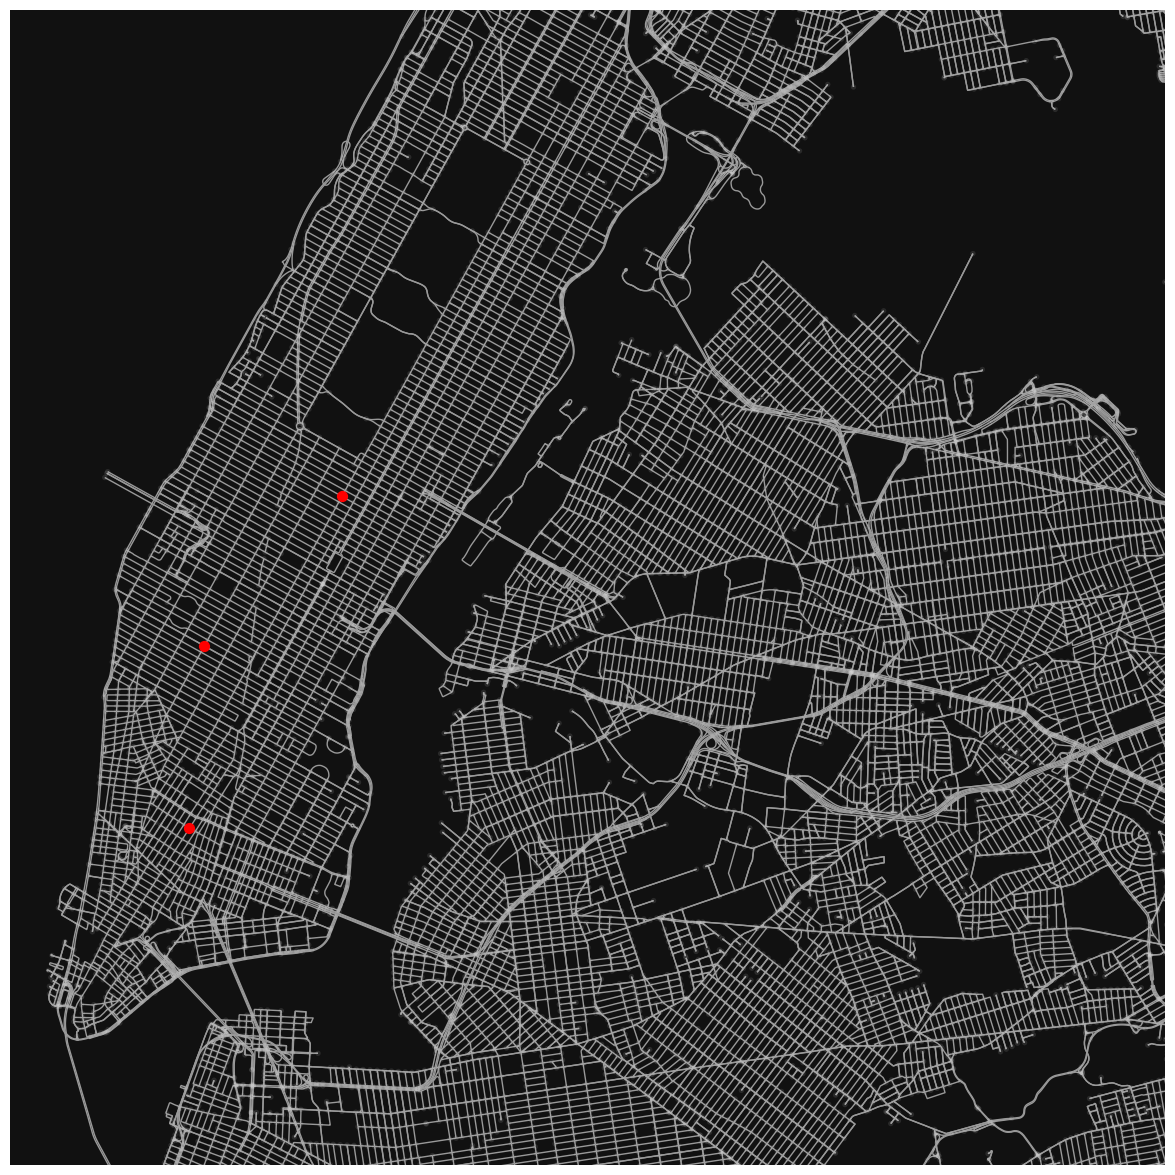

In [270]:
#require 2 stations
ttl_stops = 4
S = 1500

ttl_nodes = len(demand_vector)
node_demands = demand_vector['d']
model = Model("Max Coverage Example")

#define X_i, which determines whether a node is covered...
vars_covered_id = [f'X_{i}' for i in demand_vector.index]
vars_covered = model.addVars(vars_covered_id, vtype=GRB.INTEGER, name='placements', lb=0, ub=1) 
vars_covered_arr = np.array(list(vars_covered.values()))

#define Y_i, determining facility assignment
vars_fac_id = [f'Y_{i}' for i in demand_vector.index]
vars_fac = model.addVars(vars_fac_id, vtype=GRB.INTEGER, name='placements', lb=0, ub=1) 

#maximize covered demand...     
obj_fn = (node_demands*vars_covered_arr).sum() 
model.setObjective(obj_fn, GRB.MAXIMIZE) 

#only 2 stations allowed
model.addConstr(sum(vars_fac.values()) == ttl_stops)

#ensure a node/stop is covered by at least one facility...
for id, x_i in vars_covered.items():
    node_id = id.replace('X_', '')
    N_i = search_nearby_nodes(node_id, distances_update, S) 
    coverage_i = 0
    for y_j in N_i: 
        node_id_j = f'Y_{y_j}'
        coverage_i += vars_fac[node_id_j]
    model.addConstr(x_i <= coverage_i)

model.optimize()

assigned_stops = [
    int(i.replace('Y_', '')) for i,k in vars_fac.items() if k.X == 1
]
fig, ax = ox.plot_graph(
    G, 
    show=False, 
    close=False, 
    figsize=(15,15), 
    bbox=bbox, 
    node_alpha=0.1,
)
assigned_nodes = nodes.loc[assigned_stops[:-1]]
assigned_nodes.plot(ax=ax, color="red", markersize=50)

plt.show()